### REFERENCE

* [Introduction to Recommender systems](http://gluon.mxnet.io/chapter11_recommender-systems/intro-recommender-systems.html)
* [Matrix Factorization](http://mxnet.incubator.apache.org/tutorials/python/matrix_factorization.html)
* [Deep Matrix Factorization using Apache MXNet](https://github.com/jmschrei/notebooks/blob/master/MXNet%20Deep%20Matrix%20Factorization/MxNet_Deep_Matrix_Factorization.ipynb)
* [Movie Lens Dataset](https://grouplens.org/datasets/movielens/)

In [1]:
## SET LIBRARY
import pandas as pd
import numpy as np

import mxnet as mx
from mxnet import nd, autograd, gluon
#from mxnet.gluon.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
mx.random.seed(1071)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
## SET GLOBAL
ctx = mx.cpu(0)
gtx = mx.gpu(0)

In [3]:
## SET WORK DIRETORY
work_path = '/Users/boO/data8/boo/data.student/60.feat_study'

In [4]:
## SET PARAMS
idx_tot = 35000
idx_trn = 25000 

epochs = 30
btch_size = 16
learning_rate = 0.005

In [5]:
## LOAD DATA
tab = np.random.randn(250, 250)
wv_i = np.random.randint(250, size=idx_tot)
wv_j = np.random.randint(250, size=idx_tot)
wv_v = tab[wv_i, wv_j]
print(wv_v.shape)

(35000,)


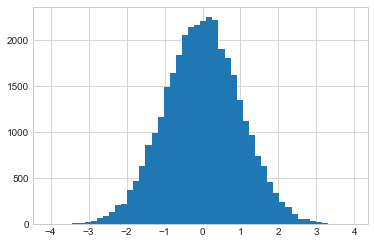

In [27]:
plt.hist(wv_v, bins=50)
plt.show()

In [6]:
xy_train = gluon.data.ArrayDataset(wv_i[:idx_trn], wv_j[:idx_trn], wv_v[:idx_trn].astype(np.float32))
xy_train = gluon.data.DataLoader(xy_train, batch_size=btch_size, shuffle=True)
xy_valid = gluon.data.ArrayDataset(wv_i[idx_trn:], wv_j[idx_trn:], wv_v[idx_trn:].astype(np.float32))
xy_valid = gluon.data.DataLoader(xy_valid, batch_size=btch_size, shuffle=True)

In [7]:
for user, item, scor in xy_valid:
    user = user.as_in_context(ctx)
    item = item.as_in_context(ctx)
    scor = scor.as_in_context(ctx)
    break
print(user)
print(item)
print(scor)


[131 160 173  81   5  39 205  34 165  99   2 215 208 235 233  81]
<NDArray 16 @cpu(0)>

[ 11  50  60 149  85   5  54 243 192  59  53 112 124 101 217  83]
<NDArray 16 @cpu(0)>

[-1.05629039 -0.29805148  0.94929832  1.2885704  -0.39073372  1.18297327
  0.94467235  0.7737698   1.76111472  0.49847716  0.88584882  0.29817027
  0.89570659 -0.13142024  0.28553584  2.23126626]
<NDArray 16 @cpu(0)>


In [27]:
class GPH(gluon.HybridBlock):
    def __init__(self, vocab_size, embd_dim, num_output, **kwargs):
        super(GPH, self).__init__(**kwargs)
        with self.name_scope():
            self.user = gluon.nn.Embedding(vocab_size, embd_dim)
            self.item = gluon.nn.Embedding(vocab_size, embd_dim)
            self.dense = gluon.nn.Dense(num_output)

    def hybrid_forward(self, F, usr, itm):
        # user latent features
        usr = self.user(usr)
        # item latent features
        itm = self.item(itm)
        # https://www.oreilly.com/ideas/deep-matrix-factorization-using-apache-mxnet
        # Define the dot product between the two variables, which is the elementwise multiplication and a sum
        #F.dot(usr, itm, transpose_b=True) #F.sum(F.dot(usr, itm, transpose_b=True), axis=1)
        pred = F.sum(F.multiply(usr, itm), axis=1) 
        pred = self.dense(pred)
        pred = F.reshape(pred,-1)
        return pred
    
gph = GPH(vocab_size=250, embd_dim=32, num_output=1)
gph.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
print(gph)

GPH(
  (user): Embedding(250 -> 32, float32)
  (item): Embedding(250 -> 32, float32)
  (dense): Dense(None -> 1, linear)
)


In [122]:
class GPH(gluon.HybridBlock):
    def __init__(self, vocab_size, embd_dim, num_hidden, num_output, **kwargs):
        super(GPH, self).__init__(**kwargs)
        with self.name_scope():
            self.user = gluon.nn.Embedding(vocab_size, embd_dim)
            self.item = gluon.nn.Embedding(vocab_size, embd_dim)
            self.dense = gluon.nn.Dense(num_hidden, activation='relu')
            self.dropout = gluon.nn.Dropout(0.5)
            self.flatten = gluon.nn.Flatten()
            self.output = gluon.nn.Dense(num_output)
            
    def hybrid_forward(self, F, usr, itm):
        # user latent features
        usr = self.user(usr)
        # item latent features
        itm = self.item(itm)
        # https://www.oreilly.com/ideas/deep-matrix-factorization-using-apache-mxnet
        # nn = mx.symbol.concat(user, movie)
        # dim (int, optional, default='1') – the dimension to be concated.
        pred = F.concat(usr,itm,dim=1)
        pred = self.flatten(pred)
        pred = self.dense(pred)
        pred = self.output(pred)
        return pred
    
gph = GPH(vocab_size=250, embd_dim=32, num_hidden=16, num_output=1)
gph.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
print(gph)

GPH(
  (user): Embedding(250 -> 32, float32)
  (item): Embedding(250 -> 32, float32)
  (dense): Dense(None -> 16, Activation(relu))
  (dropout): Dropout(p = 0.5)
  (flatten): Flatten
  (output): Dense(None -> 1, linear)
)


In [28]:
## SANDBOX
for i, (user, item, scor) in enumerate(xy_valid):
    user = user.as_in_context(ctx)
    item = item.as_in_context(ctx)
    scor = scor.as_in_context(ctx)
    break
print(user.shape)
print(item.shape)
print(scor.shape)
pred = gph(user, item)
print(pred.shape)
#print(l2loss(pred, scor))
#rmse = mx.metric.RMSE()
#rmse.update(preds=pred, labels=scor)
#print(rmse.get()[1])

(16,)
(16,)
(16,)
(16,)


In [124]:
l2loss = gluon.loss.L2Loss()
optimizer = gluon.Trainer(gph.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': 0.001})

In [89]:
def evaluator(data_iterator, gph, loss_func):
    rmse = mx.metric.RMSE()
    loss_avg = 0.
    for i, (user, item, scor) in enumerate(data_iterator):
        user = user.as_in_context(ctx)
        item = item.as_in_context(ctx)
        scor = scor.as_in_context(ctx)
        
        pred = gph(user, item)
        loss = loss_func(pred, scor)
        rmse.update(preds=pred, labels=scor)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return rmse.get()[1], loss_avg

def plot_mets(loss_tr, loss_ts, rmse_tr, rmse_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, rmse_tr)
    fg2.plot(xs, rmse_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training RMSE', 'testing RMSE'],fontsize=14)

In [ ]:
idx_mets = pd.DataFrame({'loss_tr':[],'loss_ts':[],'rmse_tr':[],'rmse_ts':[]})
n_iter = 0
for epoch in range(epochs):
    mov_loss = 0
    for i, (user, item, scor) in enumerate(xy_train):
        user = user.as_in_context(ctx)
        item = item.as_in_context(ctx)
        scor = scor.as_in_context(ctx)
        
        with autograd.record(train_mode=True):
            pred = gph(user, item)
            loss = l2loss(pred, scor)
        loss.backward()
        optimizer.step(btch_size)
        n_iter +=1
        mov_loss = .99 * mov_loss + .01 * nd.mean(loss).asscalar()
        est_loss = mov_loss/(1-0.99**n_iter)
        
    print("[%sth epoch] Loss :  %0.4f" % (epoch, est_loss))
    rmse_train, loss_train = evaluator(xy_train, gph, l2loss)
    rmse_valid, loss_valid = evaluator(xy_valid, gph, l2loss)
    print("[%sth epoch] Train RMSE :  %0.4f, Valid  RMSE :  %0.4f" % (epoch, rmse_train, rmse_valid))
    idx_mets = pd.concat([idx_mets,pd.DataFrame({'loss_tr':[loss_train],'loss_ts':[loss_valid],'rmse_tr':[rmse_train],'rmse_ts':[rmse_valid]})],axis=0,ignore_index=True)
    
plot_mets(idx_mets['loss_tr'],idx_mets['loss_ts'],idx_mets['rmse_tr'],idx_mets['rmse_ts'])

[0th epoch] Loss :  0.4971
[0th epoch] Train RMSE :  0.8009, Valid  RMSE :  0.7924
[1th epoch] Loss :  0.5048
[1th epoch] Train RMSE :  0.8004, Valid  RMSE :  0.7922
[2th epoch] Loss :  0.4891
[2th epoch] Train RMSE :  0.8000, Valid  RMSE :  0.7917
[3th epoch] Loss :  0.4961
[3th epoch] Train RMSE :  0.7997, Valid  RMSE :  0.7918
[4th epoch] Loss :  0.5183
[4th epoch] Train RMSE :  0.7995, Valid  RMSE :  0.7916
[5th epoch] Loss :  0.4984
[5th epoch] Train RMSE :  0.7993, Valid  RMSE :  0.7914
[6th epoch] Loss :  0.4980
[6th epoch] Train RMSE :  0.7991, Valid  RMSE :  0.7912
[7th epoch] Loss :  0.4887
[7th epoch] Train RMSE :  0.7989, Valid  RMSE :  0.7912
[8th epoch] Loss :  0.5033
[8th epoch] Train RMSE :  0.7988, Valid  RMSE :  0.7912
[9th epoch] Loss :  0.5214
[9th epoch] Train RMSE :  0.7986, Valid  RMSE :  0.7912
[10th epoch] Loss :  0.5017
[10th epoch] Train RMSE :  0.7985, Valid  RMSE :  0.7910
[11th epoch] Loss :  0.4974
[11th epoch] Train RMSE :  0.7983, Valid  RMSE :  0.7910
